Cacophony for the whole family
==============================

Allen Downey

This is an example that demonstrates some of the features in the *Think DSP* library.

It is inspired by the performance of a grade school band I witnessed recently.  My goal is to simulate the sound of a beginner band.


In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

First, a function that translates from a MIDI number to a frequency:

In [2]:
def midi_to_freq(midi_num):
    """Converts MIDI note number to frequency.

    midi_num: int MIDI note number
    
    returns: float frequency in Hz
    """
    x = (midi_num - 69) / 12.0
    freq = 440.0 * 2**x
    return freq

Now here's a randomized version that simulates three kinds of errors: poor tuning, playing the wrong note, and [popping an overtone](https://en.wikipedia.org/wiki/Overtone).  Notice that it is possible to make all three errors.

In [3]:
import random

def random_freq(midi_num):

    # simulate poor tuning by adding gaussian noise to the MIDI number
    midi_num += random.gauss(0, 0.5)
    
    # one kid out of 10 plays the wrong note
    if random.random() < 0.1:
        midi_num += random.randint(-5, 5)
        
    freq = midi_to_freq(midi_num)
    
    # and one kid in 10 pops an overtone
    if random.random() < 0.1:
        freq *= random.randint(2, 5)

    return freq

This function takes a MIDI number and duration and makes a Wave:

In [4]:
from thinkdsp import SawtoothSignal

def make_note(midi_num, duration, framerate=22050):
    """Make a MIDI note with the given duration.

    midi_num: int MIDI note number
    duration: float seconds
    sig_cons: Signal constructor function
    framerate: int frames per second

    returns: Wave
    """
    freq = random_freq(midi_num)
    signal = SawtoothSignal(freq) #锯齿波
    #SawtoothSignal is a subclass of Sinusoid, which is again a subclass of Signal
    wave = signal.make_wave(duration, framerate=framerate)
    wave.apodize() #apodize smoothing the signal at the beginning and at the end
    return wave

Let's test make_note.  MIDI number 60 is middle C.

In [5]:
note = make_note(60, 1.0)
note.make_audio()

Sounds good.

Now we can make 10 notes and play them at the same time.  Since Wave provides `__add__`, we can use `sum`:

In [24]:
def make_ensemble(midi_num, duration):
    notes = [make_note(midi_num, duration) for i in range(10)]
    ensemble = sum(notes)
    #ensemble.make_audio()
    return ensemble

And we can test it with a middle C:

In [30]:
c = make_ensemble(60, 1.0)
c.make_audio()

In [27]:
type(c)

thinkdsp.Wave

Good, sounds like angry bees.

And now, a rousing chorus of that old crowd favorite, _Hot Cross Buns_.

Wave provides `__or__`, which concatenates notes, so we can use `reduce`:

In [8]:
from thinkdsp import Wave
from functools import reduce

midi_nums = [64, 62, 60,     64, 62, 60,    60, 60, 60, 60,      62, 62, 62, 62,      64, 62, 60]
durations = [0.5, 0.5, 1.0,  0.5, 0.5, 1.0, 0.25, 0.25, 0.25, 0.25,  0.25, 0.25, 0.25, 0.25,  0.5, 0.5, 1.0]

waves = [make_ensemble(midi_num, duration) for midi_num, duration in zip(midi_nums, durations)]
wave = reduce(Wave.__or__, waves)
wave.make_audio()

In [10]:
Wave.__or__

<function thinkdsp.Wave.__or__(self, other)>

In [16]:
?reduce

Docstring:
reduce(function, iterable[, initial]) -> value

Apply a function of two arguments cumulatively to the items of a sequence
or iterable, from left to right, so as to reduce the iterable to a single
value.  For example, reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates
((((1+2)+3)+4)+5).  If initial is present, it is placed before the items
of the iterable in the calculation, and serves as a default when the
iterable is empty.
Type:      builtin_function_or_method


And that brings a tear of pride to any parent's eye.

On a more serious note, this example tells us something about how the ear interprets complex sounds with many tones and harmonics.

Let's take a look at the spectrum of that middle C:

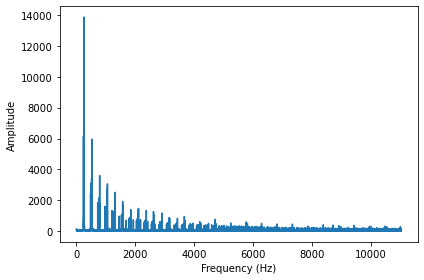

In [17]:
from thinkdsp import decorate

spectrum = c.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [36]:
type(spectrum.max_freq)

float

And we can zoom in on the first few harmonics:

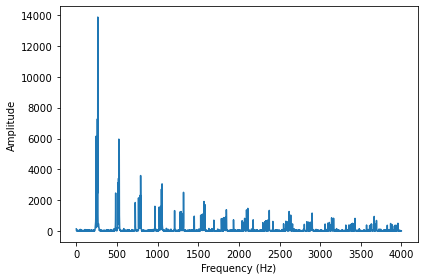

In [18]:
spectrum.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

A few observations: 

1. The kids playing out of tune have a bigger effect on the harmonics, and less effect on the fundamental, so the ear can still pick out a clear pitch, and

2. Some of the unintentional overtones overlap with the harmonics, so they change the timbre, but don't stick out as much as you might expect, 

3. The high harmonics are so spread out that they basically contribute white noise and don't affect the perceived pitch.

decorator @property can turn a method to a read_only attribute

In [45]:
class whatever:
    def __init__(self, value):
        self.value = value
    @property
    def get(self):
        return self.value

In [46]:
a = whatever(1)

In [47]:
a.value

1

In [49]:
a.get

1

In [50]:
type(a.get)

int

In [56]:
a.get

2

In [54]:
a.value = 2

In [57]:
?property

Init signature: property(fget=None, fset=None, fdel=None, doc=None)
Docstring:     
Property attribute.

  fget
    function to be used for getting an attribute value
  fset
    function to be used for setting an attribute value
  fdel
    function to be used for del'ing an attribute
  doc
    docstring

Typical use is to define a managed attribute x:

class C(object):
    def getx(self): return self._x
    def setx(self, value): self._x = value
    def delx(self): del self._x
    x = property(getx, setx, delx, "I'm the 'x' property.")

Decorators make defining new properties or modifying existing ones easy:

class C(object):
    @property
    def x(self):
        "I am the 'x' property."
        return self._x
    @x.setter
    def x(self, value):
        self._x = value
    @x.deleter
    def x(self):
        del self._x
Type:           type
Subclasses:     abstractproperty, pybind11_static_property, _deprecated_property, _deprecated_property, _deprecated_property, _deprecated_proper

In [84]:
class C(object):
    @property
    def x(self):
        "I am the 'x' property."
        return self._x
    @x.setter
    def x(self, value):
        self._x = value
    @x.deleter
    def x(self):
        del self._x

In [85]:
a = C()

In [87]:
a.x = 1

In [88]:
a.x

1

In [102]:
import inspect
inspect.getmembers(property, lambda a:not(inspect.isroutine(a)))

[('__class__', type),
 ('__doc__',
  'Property attribute.\n\n  fget\n    function to be used for getting an attribute value\n  fset\n    function to be used for setting an attribute value\n  fdel\n    function to be used for del\'ing an attribute\n  doc\n    docstring\n\nTypical use is to define a managed attribute x:\n\nclass C(object):\n    def getx(self): return self._x\n    def setx(self, value): self._x = value\n    def delx(self): del self._x\n    x = property(getx, setx, delx, "I\'m the \'x\' property.")\n\nDecorators make defining new properties or modifying existing ones easy:\n\nclass C(object):\n    @property\n    def x(self):\n        "I am the \'x\' property."\n        return self._x\n    @x.setter\n    def x(self, value):\n        self._x = value\n    @x.deleter\n    def x(self):\n        del self._x'),
 ('__isabstractmethod__',
  <attribute '__isabstractmethod__' of 'property' objects>),
 ('fdel', <member 'fdel' of 'property' objects>),
 ('fget', <member 'fget' of 'prope

In [90]:
a.x =1

In [91]:
a.x =2

In [95]:
del a.x

In [106]:
?property

Init signature: property(fget=None, fset=None, fdel=None, doc=None)
Docstring:     
Property attribute.

  fget
    function to be used for getting an attribute value
  fset
    function to be used for setting an attribute value
  fdel
    function to be used for del'ing an attribute
  doc
    docstring

Typical use is to define a managed attribute x:

class C(object):
    def getx(self): return self._x
    def setx(self, value): self._x = value
    def delx(self): del self._x
    x = property(getx, setx, delx, "I'm the 'x' property.")

Decorators make defining new properties or modifying existing ones easy:

class C(object):
    @property
    def x(self):
        "I am the 'x' property."
        return self._x
    @x.setter
    def x(self, value):
        self._x = value
    @x.deleter
    def x(self):
        del self._x
Type:           type
Subclasses:     abstractproperty, pybind11_static_property, _deprecated_property, _deprecated_property, _deprecated_property, _deprecated_proper